In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!python --version

Python 3.7.13


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import itertools
import imageio
from keras import backend
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
base_skin_dir = os.path.join("/content/drive/MyDrive/melanoma", "dataset")

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions'
    
}

classes = [lesion_type_dict[i] for i in sorted(lesion_type_dict.keys())]
classes

['Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions']

In [ ]:
skin_df = pd.read_csv(os.path.join(base_skin_dir, '/content/drive/MyDrive/melanoma/dataset/metadata.csv'))

# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df = skin_df[['image_id', 'path', 'cell_type', 'cell_type_idx']]

In [ ]:
# Now lets see the sample of tile_df to look on newly made columns
skin_df.head()

,lesion_id,image_id,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0
1,HAM_0000118,ISIC_0025030,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0
2,HAM_0002730,ISIC_0026769,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0
3,HAM_0002730,ISIC_0025661,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0
4,HAM_0001466,ISIC_0031633,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0


In [ ]:
#exploratory data analysis

In [ ]:
skin_df.isnull().sum()

lesion_id           0
image_id            0
path                0
cell_type        1098
cell_type_idx       0
dtype: int64

In [ ]:
print(skin_df.dtypes)

lesion_id        object
image_id         object
path             object
cell_type        object
cell_type_idx      int8
dtype: object


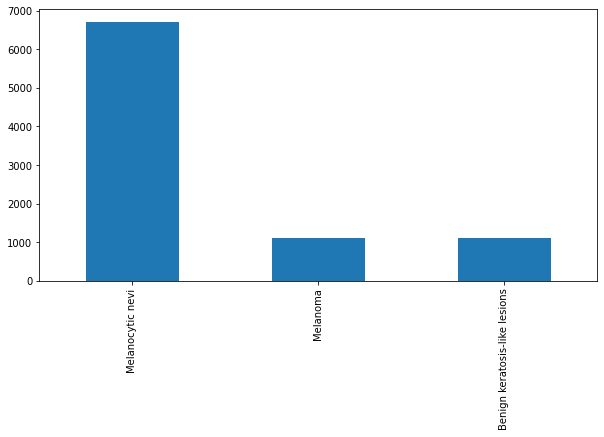

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75)))) 

In [ ]:
skin_df.head()

,lesion_id,image_id,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,/content/drive/MyDrive/melanoma/dataset/HAM100...,Benign keratosis-like lesions,0,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


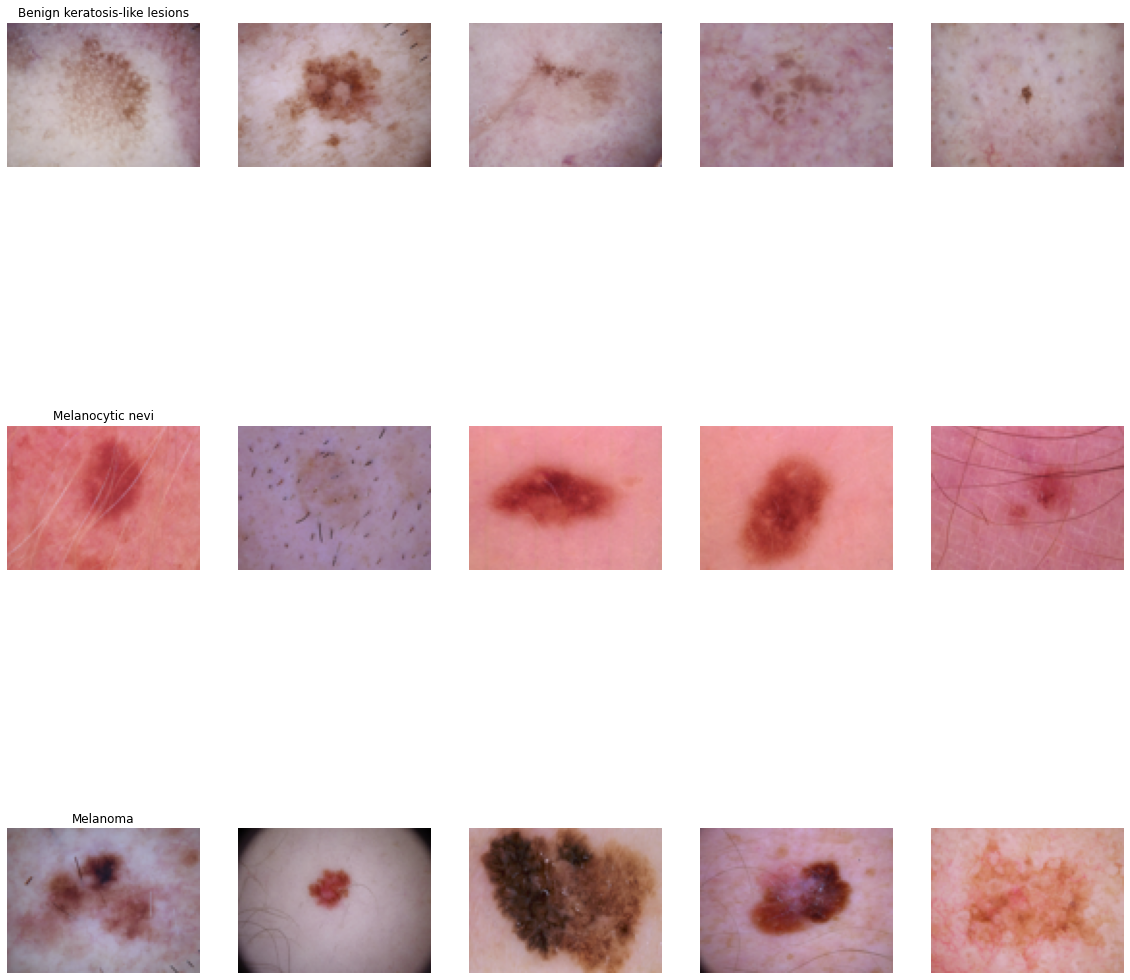

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(3, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=124).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

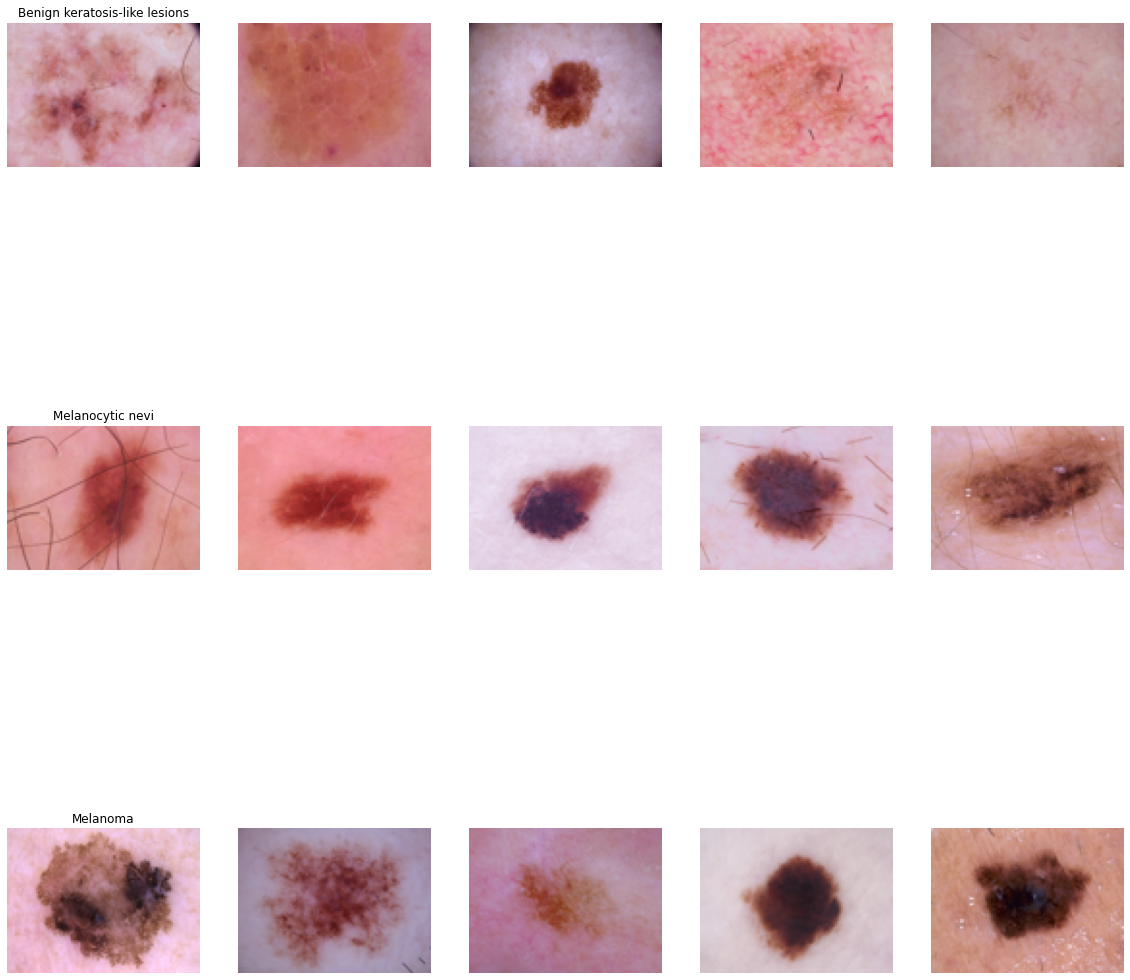

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(3, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [ ]:
skin_df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [ ]:
features = skin_df['image']
target = skin_df['cell_type_idx']

In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20, random_state=1234)

In [ ]:
x_train = np.asarray(x_train_o.tolist())
x_test = np.asarray(x_test_o.tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
y_train = to_categorical(y_train_o, num_classes = 3)
y_test = to_categorical(y_test_o, num_classes = 3)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [ ]:
def build_model():
  input_shape = (75, 100, 3)
  num_classes = 3

  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
  model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
  model.add(MaxPool2D(pool_size = (2, 2)))
  model.add(Dropout(0.25))

  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Dropout(0.40))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(num_classes, activation='softmax'))
  return model

model1 = build_model()
model2 = build_model()
model3 = build_model()
model4 = build_model()
model5 = build_model()
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

In [ ]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 

##Model1 - Without Any Augmentation

In [ ]:
datagen1 = ImageDataGenerator()
datagen1.fit(x_train)

In [ ]:
model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 25
batch_size = 64
history1 = model1.fit_generator(datagen1.flow(x_train,y_train, batch_size=batch_size),epochs = epochs, validation_data = (x_validate,y_validate),verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/25
 99/100 [============================>.] - ETA: 0s - loss: 0.8129 - accuracy: 0.6582

100/100 [==============================] - 17s 49ms/step - loss: 0.8135 - accuracy: 0.6578 - val_loss: 0.6946 - val_accuracy: 0.6787 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.6826 - accuracy: 0.6905

100/100 [==============================] - 4s 42ms/step - loss: 0.6826 - accuracy: 0.6905 - val_loss: 0.6470 - val_accuracy: 0.7349 - lr: 0.0010
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7236

100/100 [==============================] - 4s 41ms/step - loss: 0.6598 - accuracy: 0.7236 - val_loss: 0.6283 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 4/25
100/100 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.7355

100/100 [==============================] - 4s 43ms/step - loss: 0.6227 - accuracy: 0.7355 - val_loss: 0.5957 - val_accuracy: 0.7611 - lr: 0.0010
Epoch 5/25
100/100 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.7526

100/100 [==============================] - 4s 41ms/step - loss: 0.5999 - accuracy: 0.7526 - val_loss: 0.5765 - val_accuracy: 0.7604 - lr: 0.0010
Epoch 6/25
 99/100 [============================>.] - ETA: 0s - loss: 0.5725 - accuracy: 0.7631

100/100 [==============================] - 4s 41ms/step - loss: 0.5717 - accuracy: 0.7630 - val_loss: 0.5437 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 7/25
100/100 [==============================] - ETA: 0s - loss: 0.5480 - accuracy: 0.7768

100/100 [==============================] - 4s 43ms/step - loss: 0.5480 - accuracy: 0.7768 - val_loss: 0.5541 - val_accuracy: 0.7798 - lr: 0.0010
Epoch 8/25
100/100 [==============================] - ETA: 0s - loss: 0.5280 - accuracy: 0.7838

100/100 [==============================] - 4s 41ms/step - loss: 0.5280 - accuracy: 0.7838 - val_loss: 0.5355 - val_accuracy: 0.7748 - lr: 0.0010
Epoch 9/25
 99/100 [============================>.] - ETA: 0s - loss: 0.4957 - accuracy: 0.7948

100/100 [==============================] - 4s 44ms/step - loss: 0.4943 - accuracy: 0.7951 - val_loss: 0.5372 - val_accuracy: 0.7848 - lr: 0.0010
Epoch 10/25
100/100 [==============================] - ETA: 0s - loss: 0.4790 - accuracy: 0.8162

100/100 [==============================] - 5s 48ms/step - loss: 0.4790 - accuracy: 0.8162 - val_loss: 0.5509 - val_accuracy: 0.7711 - lr: 0.0010
Epoch 11/25
 99/100 [============================>.] - ETA: 0s - loss: 0.4476 - accuracy: 0.8167

100/100 [==============================] - 5s 48ms/step - loss: 0.4477 - accuracy: 0.8173 - val_loss: 0.5463 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 12/25
 99/100 [============================>.] - ETA: 0s - loss: 0.4222 - accuracy: 0.8333

100/100 [==============================] - 4s 44ms/step - loss: 0.4223 - accuracy: 0.8333 - val_loss: 0.5519 - val_accuracy: 0.7823 - lr: 0.0010
Epoch 13/25
 99/100 [============================>.] - ETA: 0s - loss: 0.3793 - accuracy: 0.8562

100/100 [==============================] - 4s 43ms/step - loss: 0.3789 - accuracy: 0.8564 - val_loss: 0.6370 - val_accuracy: 0.7954 - lr: 0.0010
Epoch 14/25
100/100 [==============================] - ETA: 0s - loss: 0.3655 - accuracy: 0.8555

100/100 [==============================] - 4s 41ms/step - loss: 0.3655 - accuracy: 0.8555 - val_loss: 0.6088 - val_accuracy: 0.7842 - lr: 0.0010
Epoch 15/25
100/100 [==============================] - ETA: 0s - loss: 0.3466 - accuracy: 0.8615

100/100 [==============================] - 4s 41ms/step - loss: 0.3466 - accuracy: 0.8615 - val_loss: 0.5868 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 16/25
100/100 [==============================] - ETA: 0s - loss: 0.3216 - accuracy: 0.8731

100/100 [==============================] - 4s 44ms/step - loss: 0.3216 - accuracy: 0.8731 - val_loss: 0.6811 - val_accuracy: 0.7760 - lr: 0.0010
Epoch 17/25
100/100 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8922

100/100 [==============================] - 5s 47ms/step - loss: 0.2820 - accuracy: 0.8922 - val_loss: 0.6950 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 18/25
100/100 [==============================] - ETA: 0s - loss: 0.2661 - accuracy: 0.8974

100/100 [==============================] - 5s 49ms/step - loss: 0.2661 - accuracy: 0.8974 - val_loss: 0.7312 - val_accuracy: 0.7817 - lr: 0.0010
Epoch 19/25
 99/100 [============================>.] - ETA: 0s - loss: 0.2428 - accuracy: 0.9105

100/100 [==============================] - 5s 46ms/step - loss: 0.2437 - accuracy: 0.9105 - val_loss: 0.7858 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 20/25
 99/100 [============================>.] - ETA: 0s - loss: 0.2132 - accuracy: 0.9151

100/100 [==============================] - 4s 43ms/step - loss: 0.2138 - accuracy: 0.9147 - val_loss: 0.7577 - val_accuracy: 0.7723 - lr: 0.0010
Epoch 21/25
100/100 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.9237

100/100 [==============================] - 4s 42ms/step - loss: 0.1998 - accuracy: 0.9237 - val_loss: 0.8300 - val_accuracy: 0.7654 - lr: 0.0010
Epoch 22/25
100/100 [==============================] - ETA: 0s - loss: 0.2138 - accuracy: 0.9165

100/100 [==============================] - 4s 42ms/step - loss: 0.2138 - accuracy: 0.9165 - val_loss: 0.8703 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 23/25
100/100 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9280

100/100 [==============================] - 4s 45ms/step - loss: 0.1945 - accuracy: 0.9280 - val_loss: 0.8379 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 24/25
100/100 [==============================] - ETA: 0s - loss: 0.1751 - accuracy: 0.9349

100/100 [==============================] - 4s 42ms/step - loss: 0.1751 - accuracy: 0.9349 - val_loss: 0.8561 - val_accuracy: 0.7779 - lr: 0.0010
Epoch 25/25
100/100 [==============================] - ETA: 0s - loss: 0.1767 - accuracy: 0.9327

100/100 [==============================] - 4s 44ms/step - loss: 0.1767 - accuracy: 0.9327 - val_loss: 0.8643 - val_accuracy: 0.7717 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


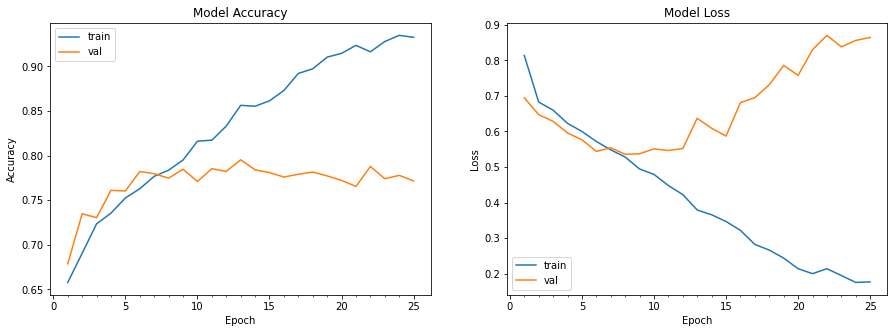

In [ ]:
plot_model_history(history1)

In [ ]:
model1.save('/content/drive/MyDrive/model1.h5')

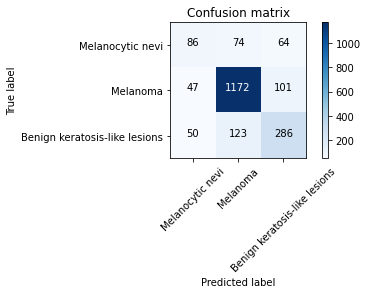

In [ ]:
# Predict the values from the validation dataset
Y_pred1 = model1.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes1 = np.argmax(Y_pred1, axis = 1) 
# Convert validation observations to one hot vectors
Y_true1 = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx1 = confusion_matrix(Y_true1, Y_pred_classes1)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx1, classes = classes)

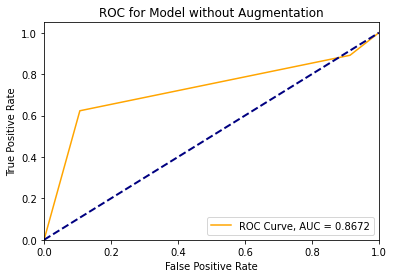

In [ ]:
#ROC curve
plt.figure()
fpr1, tpr1, thresh1 = roc_curve(Y_true1, Y_pred_classes1, pos_label=2)
auc1 = round(roc_auc_score(Y_true1, Y_pred1, multi_class='ovr'), 4)
plt.plot(fpr1,tpr1,color="orange",label="ROC Curve, AUC = "+str(auc1))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Model without Augmentation")
plt.legend(loc="lower right")
plt.show()

##Model2 - Augmenting all three categories on the fly

In [ ]:
datagen2 = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen2.fit(x_train)

In [ ]:
model2.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 25
batch_size = 64
history2 = model2.fit_generator(datagen2.flow(x_train,y_train, batch_size=batch_size),epochs = epochs, validation_data = (x_validate,y_validate),verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,callbacks=[learning_rate_reduction])

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


100/100 [==============================] - ETA: 0s - loss: 0.8717 - accuracy: 0.6525

100/100 [==============================] - 14s 139ms/step - loss: 0.8717 - accuracy: 0.6525 - val_loss: 0.7163 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.7187 - accuracy: 0.6697

100/100 [==============================] - 20s 204ms/step - loss: 0.7187 - accuracy: 0.6697 - val_loss: 0.7214 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.6704

100/100 [==============================] - 12s 123ms/step - loss: 0.7057 - accuracy: 0.6704 - val_loss: 0.6849 - val_accuracy: 0.6762 - lr: 0.0010
Epoch 4/25
100/100 [==============================] - ETA: 0s - loss: 0.6919 - accuracy: 0.6758

100/100 [==============================] - 13s 125ms/step - loss: 0.6919 - accuracy: 0.6758 - val_loss: 0.6826 - val_accuracy: 0.6787 - lr: 0.0010
Epoch 5/25
100/100 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.6861

100/100 [==============================] - 12s 124ms/step - loss: 0.6855 - accuracy: 0.6861 - val_loss: 0.7249 - val_accuracy: 0.6956 - lr: 0.0010
Epoch 6/25
100/100 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.6892

100/100 [==============================] - 12s 124ms/step - loss: 0.6785 - accuracy: 0.6892 - val_loss: 0.7142 - val_accuracy: 0.7199 - lr: 0.0010
Epoch 7/25
100/100 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.7054

100/100 [==============================] - 14s 142ms/step - loss: 0.6651 - accuracy: 0.7054 - val_loss: 0.7008 - val_accuracy: 0.7230 - lr: 0.0010
Epoch 8/25
100/100 [==============================] - ETA: 0s - loss: 0.6626 - accuracy: 0.7064

100/100 [==============================] - 13s 130ms/step - loss: 0.6626 - accuracy: 0.7064 - val_loss: 0.6749 - val_accuracy: 0.7187 - lr: 0.0010
Epoch 9/25
100/100 [==============================] - ETA: 0s - loss: 0.6470 - accuracy: 0.7147

100/100 [==============================] - 21s 209ms/step - loss: 0.6470 - accuracy: 0.7147 - val_loss: 0.6623 - val_accuracy: 0.7187 - lr: 0.0010
Epoch 10/25
100/100 [==============================] - ETA: 0s - loss: 0.6454 - accuracy: 0.7156

100/100 [==============================] - 12s 123ms/step - loss: 0.6454 - accuracy: 0.7156 - val_loss: 0.6600 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 11/25
100/100 [==============================] - ETA: 0s - loss: 0.6435 - accuracy: 0.7185

100/100 [==============================] - 24s 236ms/step - loss: 0.6435 - accuracy: 0.7185 - val_loss: 0.6574 - val_accuracy: 0.7318 - lr: 0.0010
Epoch 12/25
100/100 [==============================] - ETA: 0s - loss: 0.6380 - accuracy: 0.7231

100/100 [==============================] - 14s 135ms/step - loss: 0.6380 - accuracy: 0.7231 - val_loss: 0.6432 - val_accuracy: 0.7261 - lr: 0.0010
Epoch 13/25
100/100 [==============================] - ETA: 0s - loss: 0.6354 - accuracy: 0.7210

100/100 [==============================] - 12s 122ms/step - loss: 0.6354 - accuracy: 0.7210 - val_loss: 0.6665 - val_accuracy: 0.7193 - lr: 0.0010
Epoch 14/25
100/100 [==============================] - ETA: 0s - loss: 0.6287 - accuracy: 0.7281

100/100 [==============================] - 12s 123ms/step - loss: 0.6287 - accuracy: 0.7281 - val_loss: 0.6248 - val_accuracy: 0.7330 - lr: 0.0010
Epoch 15/25
100/100 [==============================] - ETA: 0s - loss: 0.6266 - accuracy: 0.7305

100/100 [==============================] - 12s 124ms/step - loss: 0.6266 - accuracy: 0.7305 - val_loss: 0.6507 - val_accuracy: 0.7330 - lr: 0.0010
Epoch 16/25
100/100 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.7305

100/100 [==============================] - 13s 133ms/step - loss: 0.6246 - accuracy: 0.7305 - val_loss: 0.6951 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 17/25
100/100 [==============================] - ETA: 0s - loss: 0.6166 - accuracy: 0.7349

100/100 [==============================] - 12s 121ms/step - loss: 0.6166 - accuracy: 0.7349 - val_loss: 0.6197 - val_accuracy: 0.7205 - lr: 0.0010
Epoch 18/25
100/100 [==============================] - ETA: 0s - loss: 0.6104 - accuracy: 0.7387

100/100 [==============================] - 15s 153ms/step - loss: 0.6104 - accuracy: 0.7387 - val_loss: 0.6201 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 19/25
100/100 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.7327

100/100 [==============================] - 16s 157ms/step - loss: 0.6222 - accuracy: 0.7327 - val_loss: 0.6113 - val_accuracy: 0.7498 - lr: 0.0010
Epoch 20/25
100/100 [==============================] - ETA: 0s - loss: 0.6158 - accuracy: 0.7390

100/100 [==============================] - 12s 124ms/step - loss: 0.6158 - accuracy: 0.7390 - val_loss: 0.6238 - val_accuracy: 0.7324 - lr: 0.0010
Epoch 21/25
100/100 [==============================] - ETA: 0s - loss: 0.6144 - accuracy: 0.7371

100/100 [==============================] - 13s 126ms/step - loss: 0.6144 - accuracy: 0.7371 - val_loss: 0.6119 - val_accuracy: 0.7324 - lr: 0.0010
Epoch 22/25
100/100 [==============================] - ETA: 0s - loss: 0.6065 - accuracy: 0.7382

100/100 [==============================] - 13s 125ms/step - loss: 0.6065 - accuracy: 0.7382 - val_loss: 0.6005 - val_accuracy: 0.7548 - lr: 0.0010
Epoch 23/25
100/100 [==============================] - ETA: 0s - loss: 0.5980 - accuracy: 0.7415

100/100 [==============================] - 13s 132ms/step - loss: 0.5980 - accuracy: 0.7415 - val_loss: 0.6263 - val_accuracy: 0.7130 - lr: 0.0010
Epoch 24/25
100/100 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.7417

100/100 [==============================] - 12s 124ms/step - loss: 0.6099 - accuracy: 0.7417 - val_loss: 0.6236 - val_accuracy: 0.7311 - lr: 0.0010
Epoch 25/25
100/100 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.7480

100/100 [==============================] - 12s 123ms/step - loss: 0.5975 - accuracy: 0.7480 - val_loss: 0.6065 - val_accuracy: 0.7380 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


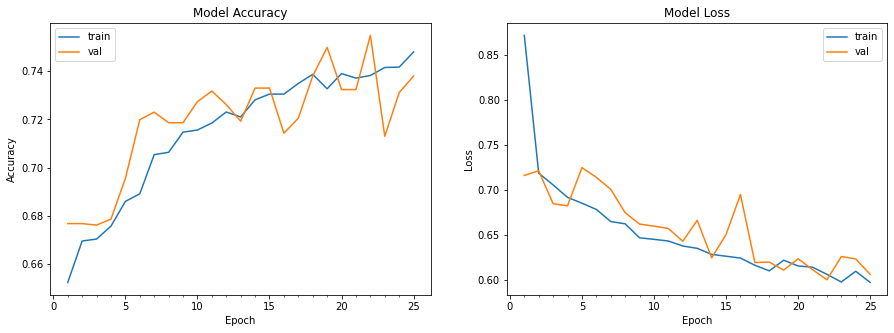

In [ ]:
plot_model_history(history2)

In [ ]:
model2.save('/content/drive/MyDrive/model2.h5')

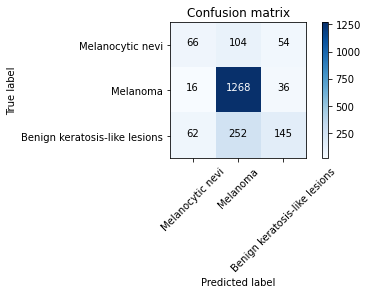

In [ ]:
# Predict the values from the validation dataset
Y_pred2 = model2.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes2 = np.argmax(Y_pred2,axis = 1) 
# Convert validation observations to one hot vectors
Y_true2 = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx2 = confusion_matrix(Y_true2, Y_pred_classes2)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx2, classes = classes)

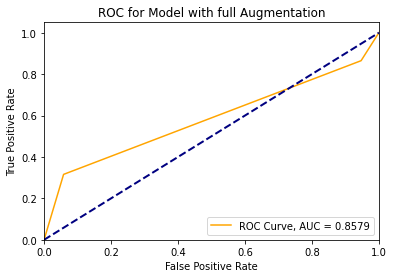

In [ ]:
#ROC curve
plt.figure()
fpr2, tpr2, thresh2 = roc_curve(Y_true2, Y_pred_classes2, pos_label=2)
auc2 = round(roc_auc_score(Y_true2, Y_pred2, multi_class='ovr'), 4)
plt.plot(fpr2,tpr2,color="orange",label="ROC Curve, AUC = "+str(auc2))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Model with full Augmentation")
plt.legend(loc="lower right")
plt.show()

##Model3 - Use dataset with only "Melanoma" category augmented

In [ ]:
aug_datagen3 = ImageDataGenerator(rotation_range =15, 
                         width_shift_range = 0.2, 
                         height_shift_range = 0.2,  
                         rescale=1./255, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip = True, 
                         fill_mode = 'nearest', 
                         data_format='channels_last', 
                         brightness_range=[0.5, 1.5])

In [ ]:
data_dir = r'/content/drive/MyDrive/melanoma/dataset2/HAM10000_images/'
skin_df2 = skin_df[['image_id', 'path', 'cell_type', 'cell_type_idx']].copy()
skin_df2['path'] = skin_df2['path'].str.replace('dataset','dataset2')
skin_df2.dropna(subset=['cell_type'],inplace=True)
data_path = []
for i,j in zip(skin_df2['path'],skin_df2['cell_type_idx']):
  if j==2:
    data_path.append(i)
data = []
for f1 in data_path:
  img = np.expand_dims(imageio.imread(f1), 0)
  data.append(img)
c = 0
for img in data:
  i = 0
  for batch in aug_datagen3.flow (img, batch_size=1, save_to_dir = data_dir, save_prefix="augment",save_format='jpg'):
    i+=1
    if i==10:
      break
  c=c+1
  if c==20:
    break

In [ ]:
for x in os.listdir(data_dir):
  if 'augment' in x:
    d = {'image_id': x, 'path': os.path.join(data_dir,x), 'cell_type': 'Melanoma', 'cell_type_idx': 2}
    skin_df2 = skin_df2.append(d, ignore_index = True)

In [ ]:
skin_df2['image'] = skin_df2['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [ ]:
skin_df2['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    9113
Name: image, dtype: int64

In [ ]:
features2 = skin_df2['image']
target2 = skin_df2['cell_type_idx']

x_train_o2, x_test_o2, y_train_o2, y_test_o2 = train_test_split(features2, target2, test_size=0.20, random_state=1234)

x_train2 = np.asarray(x_train_o2.tolist())
x_test2 = np.asarray(x_test_o2.tolist())

x_train_mean2 = np.mean(x_train2)
x_train_std2 = np.std(x_train2)

x_test_mean2 = np.mean(x_test2)
x_test_std2 = np.std(x_test2)

x_train2 = (x_train2 - x_train_mean2)/x_train_std2
x_test2 = (x_test2 - x_test_mean2)/x_test_std2

y_train2 = to_categorical(y_train_o2, num_classes = 3)
y_test2 = to_categorical(y_test_o2, num_classes = 3)

x_train2, x_validate2, y_train2, y_validate2 = train_test_split(x_train2, y_train2, test_size = 0.2, random_state = 2)

x_train2 = x_train2.reshape(x_train2.shape[0], *(75, 100, 3))
x_test2 = x_test2.reshape(x_test2.shape[0], *(75, 100, 3))
x_validate2 = x_validate2.reshape(x_validate2.shape[0], *(75, 100, 3))

In [ ]:
datagen3 = ImageDataGenerator()
datagen3.fit(x_train2)
model3.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [ ]:
epochs = 25
batch_size = 64
history3 = model3.fit_generator(datagen3.flow(x_train2,y_train2, batch_size=batch_size),epochs = epochs, validation_data = (x_validate2,y_validate2),verbose = 1, steps_per_epoch=x_train2.shape[0] // batch_size,callbacks=[learning_rate_reduction])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch 1/25
 99/100 [============================>.] - ETA: 0s - loss: 0.9289 - accuracy: 0.6626

100/100 [==============================] - 6s 45ms/step - loss: 0.9282 - accuracy: 0.6619 - val_loss: 0.7306 - val_accuracy: 0.6769 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - ETA: 0s - loss: 0.7307 - accuracy: 0.6745

100/100 [==============================] - 4s 40ms/step - loss: 0.7307 - accuracy: 0.6745 - val_loss: 0.7740 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 3/25
100/100 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.6922

100/100 [==============================] - 4s 40ms/step - loss: 0.7141 - accuracy: 0.6922 - val_loss: 0.6988 - val_accuracy: 0.6862 - lr: 0.0010
Epoch 4/25
100/100 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.7010

100/100 [==============================] - 4s 40ms/step - loss: 0.7027 - accuracy: 0.7010 - val_loss: 0.6708 - val_accuracy: 0.7012 - lr: 0.0010
Epoch 5/25
100/100 [==============================] - ETA: 0s - loss: 0.6895 - accuracy: 0.7059

100/100 [==============================] - 4s 40ms/step - loss: 0.6895 - accuracy: 0.7059 - val_loss: 0.6606 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 6/25
100/100 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.7149

100/100 [==============================] - 4s 42ms/step - loss: 0.6867 - accuracy: 0.7149 - val_loss: 0.6497 - val_accuracy: 0.7274 - lr: 0.0010
Epoch 7/25
 99/100 [============================>.] - ETA: 0s - loss: 0.6706 - accuracy: 0.7214

100/100 [==============================] - 4s 40ms/step - loss: 0.6702 - accuracy: 0.7217 - val_loss: 0.6597 - val_accuracy: 0.7293 - lr: 0.0010
Epoch 8/25
100/100 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.7247

100/100 [==============================] - 4s 40ms/step - loss: 0.6660 - accuracy: 0.7247 - val_loss: 0.7178 - val_accuracy: 0.7305 - lr: 0.0010
Epoch 9/25
100/100 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.7198

100/100 [==============================] - 4s 40ms/step - loss: 0.6718 - accuracy: 0.7198 - val_loss: 0.6364 - val_accuracy: 0.7361 - lr: 0.0010
Epoch 10/25
100/100 [==============================] - ETA: 0s - loss: 0.6498 - accuracy: 0.7310

100/100 [==============================] - 4s 40ms/step - loss: 0.6498 - accuracy: 0.7310 - val_loss: 0.6587 - val_accuracy: 0.7449 - lr: 0.0010
Epoch 11/25
 99/100 [============================>.] - ETA: 0s - loss: 0.6433 - accuracy: 0.7344

100/100 [==============================] - 4s 42ms/step - loss: 0.6426 - accuracy: 0.7344 - val_loss: 0.6194 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 12/25
 99/100 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.7382

100/100 [==============================] - 4s 40ms/step - loss: 0.6369 - accuracy: 0.7395 - val_loss: 0.6118 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 13/25
100/100 [==============================] - ETA: 0s - loss: 0.6235 - accuracy: 0.7403

100/100 [==============================] - 4s 40ms/step - loss: 0.6235 - accuracy: 0.7403 - val_loss: 0.6360 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 14/25
100/100 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.7541

100/100 [==============================] - 4s 40ms/step - loss: 0.6040 - accuracy: 0.7541 - val_loss: 0.6080 - val_accuracy: 0.7536 - lr: 0.0010
Epoch 15/25
100/100 [==============================] - ETA: 0s - loss: 0.5982 - accuracy: 0.7535

100/100 [==============================] - 4s 40ms/step - loss: 0.5982 - accuracy: 0.7535 - val_loss: 0.5880 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 16/25
100/100 [==============================] - ETA: 0s - loss: 0.5929 - accuracy: 0.7603

100/100 [==============================] - 4s 40ms/step - loss: 0.5929 - accuracy: 0.7603 - val_loss: 0.5926 - val_accuracy: 0.7586 - lr: 0.0010
Epoch 17/25
100/100 [==============================] - ETA: 0s - loss: 0.5757 - accuracy: 0.7691

100/100 [==============================] - 4s 42ms/step - loss: 0.5757 - accuracy: 0.7691 - val_loss: 0.5839 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 18/25
100/100 [==============================] - ETA: 0s - loss: 0.5653 - accuracy: 0.7697

100/100 [==============================] - 4s 40ms/step - loss: 0.5653 - accuracy: 0.7697 - val_loss: 0.6054 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 19/25
100/100 [==============================] - ETA: 0s - loss: 0.5543 - accuracy: 0.7721

100/100 [==============================] - 4s 40ms/step - loss: 0.5543 - accuracy: 0.7721 - val_loss: 0.6131 - val_accuracy: 0.7629 - lr: 0.0010
Epoch 20/25
100/100 [==============================] - ETA: 0s - loss: 0.5490 - accuracy: 0.7724

100/100 [==============================] - 4s 40ms/step - loss: 0.5490 - accuracy: 0.7724 - val_loss: 0.5960 - val_accuracy: 0.7523 - lr: 0.0010
Epoch 21/25
100/100 [==============================] - ETA: 0s - loss: 0.5475 - accuracy: 0.7803

100/100 [==============================] - 4s 42ms/step - loss: 0.5475 - accuracy: 0.7803 - val_loss: 0.5870 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 22/25
100/100 [==============================] - ETA: 0s - loss: 0.5382 - accuracy: 0.7814

100/100 [==============================] - 4s 40ms/step - loss: 0.5382 - accuracy: 0.7814 - val_loss: 0.5916 - val_accuracy: 0.7648 - lr: 0.0010
Epoch 23/25
100/100 [==============================] - ETA: 0s - loss: 0.5339 - accuracy: 0.7880

100/100 [==============================] - 4s 40ms/step - loss: 0.5339 - accuracy: 0.7880 - val_loss: 0.5757 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 24/25
100/100 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.7904

100/100 [==============================] - 4s 40ms/step - loss: 0.5270 - accuracy: 0.7904 - val_loss: 0.5858 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 25/25
100/100 [==============================] - ETA: 0s - loss: 0.5164 - accuracy: 0.7946

100/100 [==============================] - 4s 43ms/step - loss: 0.5164 - accuracy: 0.7946 - val_loss: 0.5967 - val_accuracy: 0.7723 - lr: 0.0010


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


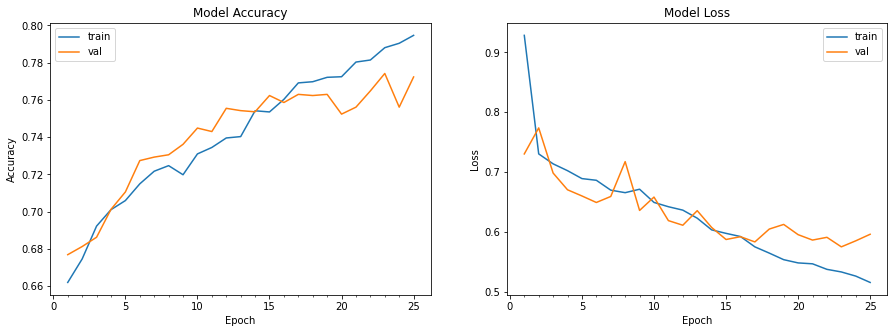

In [ ]:
plot_model_history(history3)

In [ ]:
model3.save('/content/drive/MyDrive/model3.h5')

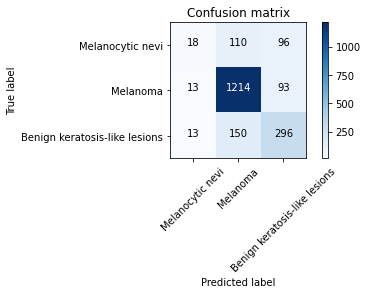

In [ ]:
# Predict the values from the validation dataset
Y_pred3 = model3.predict(x_test2)
# Convert predictions classes to one hot vectors 
Y_pred_classes3 = np.argmax(Y_pred3,axis = 1) 
# Convert validation observations to one hot vectors
Y_true3 = np.argmax(y_test2,axis = 1) 
# compute the confusion matrix
confusion_mtx3 = confusion_matrix(Y_true3, Y_pred_classes3)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx3, classes = classes)

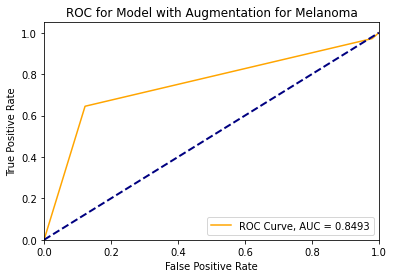

In [ ]:
#ROC curve
plt.figure()
fpr3, tpr3, thresh3 = roc_curve(Y_true3, Y_pred_classes3, pos_label=2)
auc3 = round(roc_auc_score(Y_true3, Y_pred3, multi_class='ovr'), 4)
plt.plot(fpr3,tpr3,color="orange",label="ROC Curve, AUC = "+str(auc3))
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC for Model with Augmentation for Melanoma")
plt.legend(loc="lower right")
plt.show()